In [1]:
import random
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Loading the merged train and test dataset

train_data = pd.read_pickle('../input/ieee-cis-fraud-detection-advanced-fe/advanced_fe_train.pkl')
test_data = pd.read_pickle('../input/ieee-cis-fraud-detection-advanced-fe/advanced_fe_test.pkl')

In [3]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("\n Test Data Shape : {} \n".format(test_data.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590538, 309) 


 Test Data Shape : (506691, 308) 

*********************************************


In [4]:
with open("../input/ieee-cis-fraud-detection-advanced-fe/features_having_covariate_shift.pkl", 'rb') as handle:
  drop_cols = pickle.load(handle)

### Utility Functions
<br>

In [5]:
def hyperparam_vs_auc(train_roc_auc, cv_roc_auc):
    
    '''
        Utility Function to plot the Training and Cross Validation ROC-AUC Values
        for different Hyperparameter.
    '''
    
    plt.plot(range(len(train_roc_auc)), train_roc_auc, label='Train AUC')
    plt.plot(range(len(cv_roc_auc)), cv_roc_auc, label='CV AUC')

    plt.scatter(range(len(train_roc_auc)), train_roc_auc, label='Train AUC points')
    plt.scatter(range(len(cv_roc_auc)), cv_roc_auc, label='CV AUC points')
    
    plt.xticks(range(len(train_roc_auc)))
    plt.legend()
    plt.xlabel("Hyperparameter Index")
    plt.ylabel("AUC")
    plt.title("\n Hyperparameter vs ROC-AUC \n")
    plt.grid()
    plt.show()

## Data Preparation
<br>

### Splitting the Dataset
<br>

In [6]:
X_train = train_data.drop(['isFraud']+drop_cols, axis=1)
y_train = train_data['isFraud']

X_test = test_data.drop(drop_cols, axis=1)

del train_data, test_data

In [7]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(X_train.shape))
print("\n Test Data Shape : {} \n".format(X_test.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590538, 296) 


 Test Data Shape : (506691, 296) 

*********************************************


<br>

## Hyperparameter Tuning

<br>

In [8]:
# Hyperparameters

learning_rate = [2e-2, 3e-1, 1e-1]
max_depth = [8, 12, 16]
subsample = [0.6,0.8,1]
colsample_bytree = [0.6,0.8,1]

In [9]:
results = {}

dtrain = xgb.DMatrix(X_train, label=y_train)

for rate in learning_rate:
  for depth in max_depth:
    for sample in subsample:
      for colsample in colsample_bytree:

        params = {
          'objective' : 'binary:logistic',
          'eval_metric' : 'auc',
          'learning_rate' : rate,
          'max_depth' : depth,
          'subsample' : sample,
          'colsample_bytree' : colsample,
          'tree_method' : 'gpu_hist',
          'random_state' : 3,
        }

        history = xgb.cv(
            params,
            dtrain,
            num_boost_round = 3000,
            nfold = 3,
            metrics ='auc',
            early_stopping_rounds = 100,
            verbose_eval=100,
            seed=3,
            shuffle = False
        )

        name = "learning_rate : "+str(rate)+" max_depth : "+str(depth)+" subsample : "+str(sample)+" colsample_bytree : "+str(colsample)
        results[name] = (history.iloc[-1]['train-auc-mean'],history.iloc[-1]['test-auc-mean'])

[0]	train-auc:0.80857+0.00875	test-auc:0.79524+0.00485
[100]	train-auc:0.91721+0.00399	test-auc:0.88100+0.00905
[200]	train-auc:0.95360+0.00210	test-auc:0.90300+0.00984
[300]	train-auc:0.96928+0.00136	test-auc:0.91323+0.00901
[400]	train-auc:0.97729+0.00053	test-auc:0.91827+0.00887
[500]	train-auc:0.98224+0.00056	test-auc:0.92063+0.00882
[600]	train-auc:0.98605+0.00041	test-auc:0.92196+0.00863
[700]	train-auc:0.98878+0.00025	test-auc:0.92248+0.00865
[800]	train-auc:0.99099+0.00014	test-auc:0.92260+0.00855
[900]	train-auc:0.99284+0.00007	test-auc:0.92259+0.00862
[926]	train-auc:0.99329+0.00006	test-auc:0.92258+0.00858
[0]	train-auc:0.80624+0.00900	test-auc:0.79297+0.00455
[100]	train-auc:0.91673+0.00450	test-auc:0.87965+0.00917
[200]	train-auc:0.95457+0.00214	test-auc:0.90268+0.00965
[300]	train-auc:0.97037+0.00142	test-auc:0.91286+0.00948
[400]	train-auc:0.97808+0.00088	test-auc:0.91777+0.00861
[500]	train-auc:0.98292+0.00067	test-auc:0.92047+0.00832
[600]	train-auc:0.98662+0.00039	tes

In [10]:
# Save the Results
with open('xgb_cv_results.pkl', 'wb') as handle:
    pickle.dump(results, handle)

In [11]:
# Load the Results
with open('xgb_cv_results.pkl', 'rb') as handle:
    results = pickle.load(handle)

In [12]:
train_roc_auc = [auc[0] for auc in results.values()]
cv_roc_auc = [auc[1] for auc in results.values()]

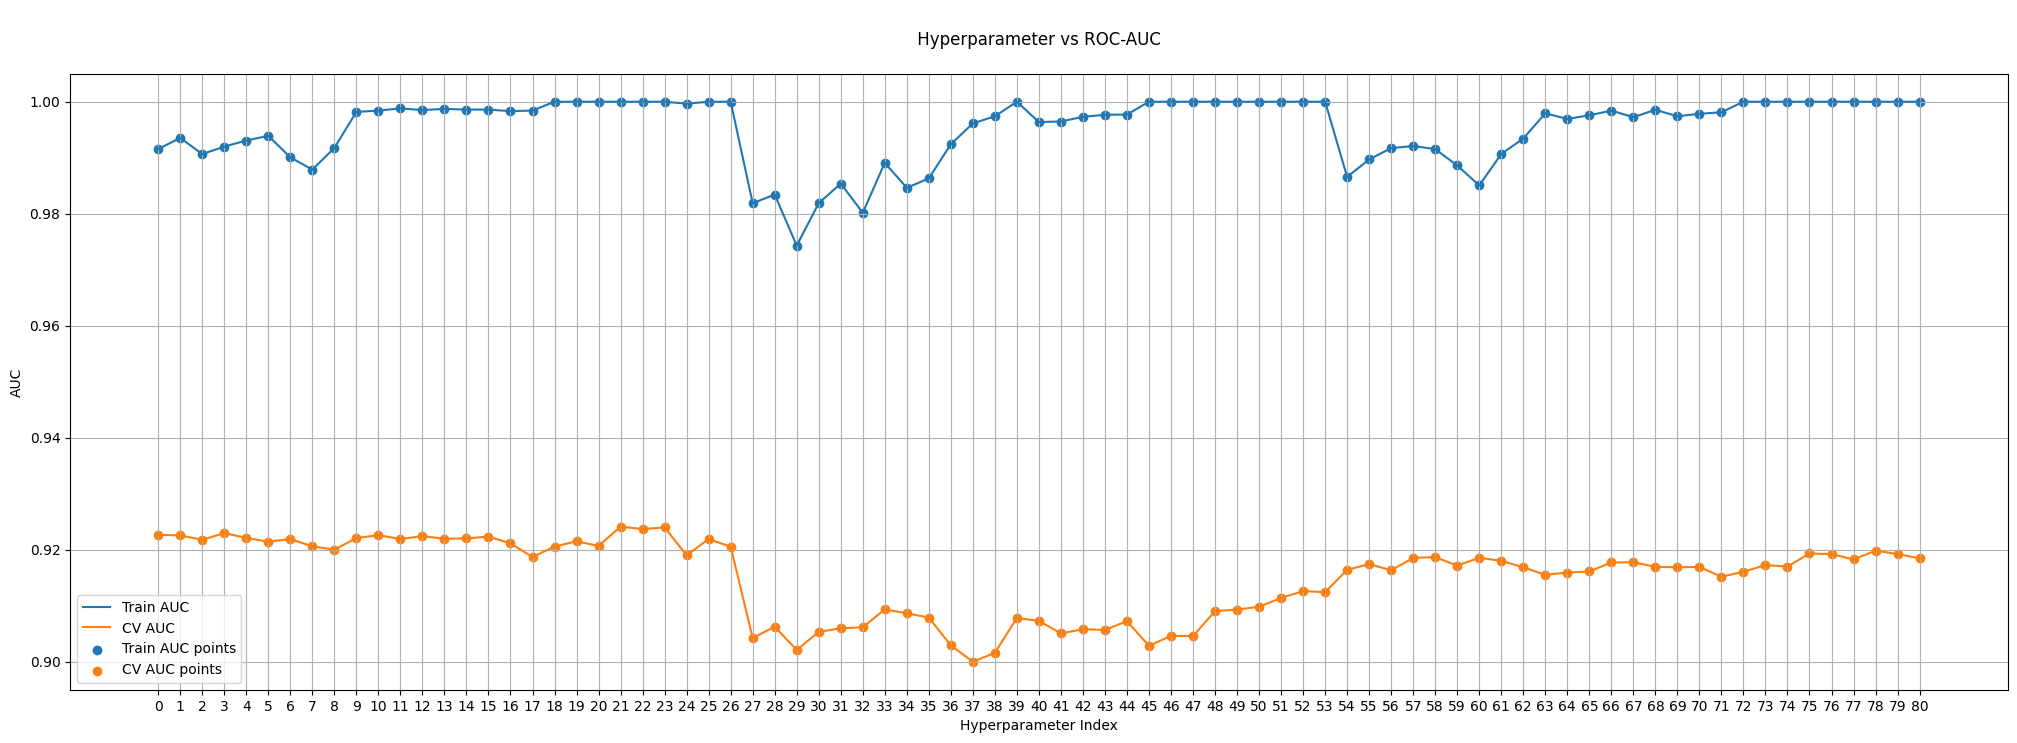

In [13]:
plt.figure(figsize=(25,8))
hyperparam_vs_auc(train_roc_auc, cv_roc_auc)

From the above plot, the best hyperaparameter index is 3.
<br><br>

In [14]:
best_params = list(results.keys())[3]

In [15]:
print("The Best Paramaters are {} ".format(best_params))

The Best Paramaters are learning_rate : 0.02 max_depth : 8 subsample : 0.8 colsample_bytree : 0.6 
